## Imports, Configurations, and Paths

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
from pandas.io.formats.style import Styler

# Stats and Utilities
import os
import itertools
import warnings
from IPython.display import display
from typing import Dict, List, Tuple

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, Birch
from sklearn.mixture import GaussianMixture
import hdbscan

In [2]:
# CONFIGURATION
RANDOM_STATE = 42
DATA_PATH = "./Data/telecom_preprocessed.csv"
ORIGINAL_PATH = "./Data/Telecom/Telecom_customer_dataset.csv"
TOP_K_FEATURES = 10
pd.set_option("display.max_columns", 50)

## HELPER FUNCTIONS

### Data Loading and Scaling

In [3]:
# Load the pre‑processed dataset
def load_dataset(path: str = DATA_PATH) -> pd.DataFrame:
    return pd.read_csv(path)

In [4]:
# Return a standard‑scaled copy of the data and the fitted scaler
def scale_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, StandardScaler]:
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df.values),
        columns=df.columns,
        index=df.index,
    )
    return df_scaled, scaler

In [5]:
# Convert scaled data back to original units using the original dataset
def inverse_scale(
    df_scaled: pd.DataFrame,
    scaler: StandardScaler,
    original_path: str = ORIGINAL_PATH,
) -> pd.DataFrame:
    df_original = pd.read_csv(original_path)
    common_cols = [c for c in df_scaled.columns if c in df_original.columns]
    df_inv = pd.DataFrame(
        scaler.inverse_transform(df_scaled[common_cols]),
        columns=common_cols,
        index=df_scaled.index,
    )
    return df_inv

### Cluster Metrics

In [6]:
# Compute clustering quality indices (Silhouette, Davies–Bouldin, Calinski–Harabasz)
def clustering_metrics(X: np.ndarray, labels: np.ndarray) -> Dict[str, float]:
    unique = np.setdiff1d(np.unique(labels), [-1])  # ignore noise label -1
    if len(unique) < 2:
        return {"silhouette": np.nan, "davies": np.nan, "calinski": np.nan}

    return {
        "silhouette": silhouette_score(X, labels),
        "davies": davies_bouldin_score(X, labels),
        "calinski": calinski_harabasz_score(X, labels),
    }

### Tabular Cluster Explanations

In [7]:
# Summarize each cluster with top-k features by within-cluster variance
def cluster_summary(
    df: pd.DataFrame,
    labels: np.ndarray,
    top_k_features: int = TOP_K_FEATURES,
) -> pd.DataFrame:
    labelled = df.copy()
    labelled["cluster"] = labels

    variances = (
        labelled.groupby("cluster")
        .var(numeric_only=True)
        .median()
        .sort_values(ascending=False)
    )
    top_features = variances.head(top_k_features).index.tolist()

    summary = (
        labelled.groupby("cluster")[top_features]
        .agg(["count", "mean", "std", "min", "max"])
        .swaplevel(axis=1)
        .sort_index(axis=1, level=0)
    )
    return summary

In [8]:
# List top-variable features per cluster by variance
def top_variable(
    df: pd.DataFrame,
    labels: np.ndarray,
    n_features: int = TOP_K_FEATURES,
    cluster_col: str = "cluster",
) -> Dict[int, List[str]]:
    labelled = df.copy()
    labelled[cluster_col] = labels

    num_cols = labelled.select_dtypes(include="number").columns.difference([cluster_col])
    result: Dict[int, List[str]] = {}
    for cid, grp in labelled.groupby(cluster_col):
        result[cid] = (
            grp[num_cols]
            .var()
            .sort_values(ascending=False)
            .head(n_features)
            .index.tolist()
        )
    return result

In [9]:
# Display a styled summary table in notebooks
def show_summary(
    summary: pd.DataFrame,
    caption: str = "Cluster summary (top features)",
) -> pd.io.formats.style.Styler:
    sty = (
        summary.style
        .set_caption(caption)
        .background_gradient(axis=None, cmap="Blues", vmin=summary.min().min())
        .format(precision=2)
    )
    display(sty)
    return sty

### Visualization Helpers

In [10]:
# Plot PCA two‑dimensional scatter of clusters
def plot_pca(X: pd.DataFrame, labels: np.ndarray, n_components: int = 2) -> None:
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    coords = pca.fit_transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=labels, palette="tab10", s=60, edgecolor="k")
    plt.title("PCA Projection of Clusters")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.tight_layout()
    plt.show()

In [11]:
# Plot t‑SNE two‑dimensional scatter of clusters
def plot_tsne(X: pd.DataFrame, labels: np.ndarray, perplexity: int = 30, lr: int = 200) -> None:
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=lr, random_state=RANDOM_STATE, init="pca")
    coords = tsne.fit_transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=labels, palette="tab10", s=60, edgecolor="k")
    plt.title("t‑SNE Projection of Clusters")
    plt.xlabel("t‑SNE 1")
    plt.ylabel("t‑SNE 2")
    plt.tight_layout()
    plt.show()

In [12]:
# Plot feature distribution heatmap for selected top features
def plot_cluster_heatmap(df: pd.DataFrame, labels: np.ndarray, top_features: list) -> None:
    df = df[top_features].copy()
    df["cluster"] = labels
    heat_data = df.groupby("cluster").median()
    plt.figure(figsize=(10, 6))
    sns.heatmap(heat_data, annot=True, fmt=".2f", cmap="viridis")
    plt.title("Median Feature Values per Cluster")
    plt.tight_layout()
    plt.show()

In [13]:
# Plot boxplots of chosen features split by cluster
def plot_feature_boxplots(df: pd.DataFrame, labels: np.ndarray, features: list) -> None:
    df = df.copy()
    df["cluster"] = labels
    for feature in features:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")
        plt.title(f"{feature} Distribution by Cluster")
        plt.tight_layout()
        plt.show()


In [14]:
# Plot parallel coordinates chart of cluster centres
def plot_parallel_coordinates(df: pd.DataFrame, labels: np.ndarray, top_features: list, sample_size: int = 1000) -> None:
    sample_df = df[top_features].copy()
    sample_df["cluster"] = labels
    if len(sample_df) > sample_size:
        sample_df = sample_df.sample(sample_size, random_state=RANDOM_STATE)
    plt.figure(figsize=(10, 6))
    pd.plotting.parallel_coordinates(sample_df, "cluster", colormap="tab10", alpha=0.4)
    plt.title("Parallel Coordinates of Top Features by Cluster")
    plt.tight_layout()
    plt.show()

In [15]:
# Plot radar chart of cluster centroids
def plot_radar_chart(df: pd.DataFrame, labels: np.ndarray, top_features: list) -> None:
    centroid_df = (
        df[top_features]
        .assign(cluster=labels)
        .groupby("cluster")
        .median()
    )
    categories = list(centroid_df.columns)
    n_clusters = centroid_df.shape[0]
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    plt.figure(figsize=(8, 8))
    for idx in range(n_clusters):
        values = centroid_df.iloc[idx].tolist()
        values += values[:1]
        plt.polar(angles, values, marker="o", label=f"Cluster {idx}")
    plt.xticks(angles[:-1], categories, fontsize=8)
    plt.title("Cluster Centroid Radar Chart", y=1.08)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

### Algorithm Helpers

#### K-Means

In [16]:
# Run K‑Means clustering and generate metrics, tables, and visualisations
def run_kmeans(X_scaled: np.ndarray, df_original: pd.DataFrame, n_clusters: int = 3, top_n: int = 10, random_state: int = RANDOM_STATE, use_original: bool = False):
    km = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = km.fit_predict(X_scaled)
    metrics = compute_cluster_metrics(X_scaled, labels)
    df_for_stats = df_original if use_original else pd.DataFrame(X_scaled, columns=df_original.columns)
    summary = cluster_summary(df_for_stats, labels)
    top_vars = top_variable(df_for_stats, labels, n_features=top_n)
    show_styled_df(summary, caption="K‑Means per‑cluster summary")
    plot_pca(X_scaled, labels, f"K‑Means (k={n_clusters}) – PCA 2‑D")
    plot_cluster_heatmap(df_for_stats, labels, top_vars, "K‑Means median feature heatmap")
    plot_parallel_coordinates(df_original, labels, top_vars, "K‑Means parallel coordinates", use_original)
    return {"labels": labels, "metrics": metrics, "summary": summary, "top_vars": top_vars}

#### GMM

In [17]:
# Run GMM clustering and generate metrics, tables, and visualisations
def run_gmm(X_scaled: np.ndarray, df_original: pd.DataFrame, n_components: int = 6, top_n: int = 10, random_state: int = RANDOM_STATE, use_original: bool = False):
    gmm = GaussianMixture(n_components=n_components, random_state=random_state)
    labels = gmm.fit_predict(X_scaled)
    metrics = compute_cluster_metrics(X_scaled, labels)
    df_for_stats = df_original if use_original else pd.DataFrame(X_scaled, columns=df_original.columns)
    summary = cluster_summary(df_for_stats, labels)
    top_vars = top_variable(df_for_stats, labels, n_features=top_n)
    show_styled_df(summary, caption="GMM per‑cluster summary")
    plot_pca(X_scaled, labels, f"GMM (k={n_components}) – PCA 2‑D")
    plot_cluster_heatmap(df_for_stats, labels, top_vars, "GMM median feature heatmap")
    plot_parallel_coordinates(df_original, labels, top_vars, "GMM parallel coordinates", use_original)
    return {"labels": labels, "metrics": metrics, "summary": summary, "top_vars": top_vars}

#### BIRCH

In [18]:
# Run Birch
def run_birch(X_scaled: np.ndarray, df_original: pd.DataFrame, threshold: float = 0.5, k_final: int = 4, top_n: int = 10, random_state: int = RANDOM_STATE, use_original: bool = False):
    birch = Birch(n_clusters=None, threshold=threshold)
    labels_sub = birch.fit_predict(X_scaled)
    centres    = birch.subcluster_centers_
    km_final   = KMeans(n_clusters=k_final, random_state=random_state)
    labels_final = km_final.fit_predict(centres)
    labels = np.array([labels_final[idx] for idx in labels_sub])
    metrics = compute_cluster_metrics(X_scaled, labels)
    df_for_stats = df_original if use_original else pd.DataFrame(X_scaled, columns=df_original.columns)
    summary = cluster_summary(df_for_stats, labels)
    top_vars = top_variable(df_for_stats, labels, n_features=top_n)
    show_styled_df(summary, caption="Birch per‑cluster summary")
    plot_pca(X_scaled, labels, f"Birch (k={k_final}) – PCA 2‑D")
    plot_cluster_heatmap(df_for_stats, labels, top_vars, "Birch median feature heatmap")
    plot_parallel_coordinates(df_original, labels, top_vars, "Birch parallel coordinates", use_original)
    return {"labels": labels, "metrics": metrics, "summary": summary, "top_vars": top_vars}

#### HDBSCAN

In [19]:
# Run density‑based HDBSCAN clustering and generate outputs (set use_original=True for original dataset)
def run_hdbscan(X_scaled: np.ndarray, df_original: pd.DataFrame, min_cluster_size: int = 50, min_samples: int = 10, top_n: int = 10, use_original: bool = False):
    hdb = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric="euclidean",
        core_dist_n_jobs=-1,
        prediction_data=False,
    )
    labels = hdb.fit_predict(X_scaled)
    metrics = compute_cluster_metrics(X_scaled, labels)
    df_for_stats = df_original if use_original else pd.DataFrame(X_scaled, columns=df_original.columns)
    summary = cluster_summary(df_for_stats, labels)
    top_vars = top_variable(df_for_stats, labels, n_features=top_n)
    show_styled_df(summary, caption="HDBSCAN per‑cluster summary")
    plot_pca(X_scaled, labels, "HDBSCAN – PCA 2‑D")
    plot_cluster_heatmap(df_for_stats, labels, top_vars, "HDBSCAN median feature heatmap")
    plot_parallel_coordinates(df_original, labels, top_vars, "HDBSCAN parallel coordinates", use_original)
    return {"labels": labels, "metrics": metrics, "summary": summary, "top_vars": top_vars}

## DATA LOADING

In [20]:
df_scaled = load_dataset(DATA_PATH)

In [21]:
cols_to_drop = ["Customer_ID", "churn"]

df_original = load_dataset(ORIGINAL_PATH)
df_original = df_original.drop(columns=cols_to_drop, errors="ignore")

## K-MEANS

In [22]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
kmeans_labels = kmeans.fit_predict(df_scaled)

In [23]:
kmeans_metrics = clustering_metrics(df_scaled, kmeans_labels)
kmeans_metrics

{'silhouette': 0.38587865199543203,
 'davies': 1.2291604823824045,
 'calinski': 29745.07630735441}

In [24]:
df_kmeans_labeled = df_original.copy()
df_kmeans_labeled["cluster"] = kmeans_labels

In [25]:
kmeans_summary = cluster_summary(df_kmeans_labeled, kmeans_labels)
show_summary(kmeans_summary, caption="KMeans Cluster Summary")

In [26]:
kmeans_top_vars = top_variable(df_kmeans_labeled, kmeans_labels)
kmeans_top_vars

{0: ['totmou',
  'adjmou',
  'totcalls',
  'adjqty',
  'totrev',
  'adjrev',
  'avg3mou',
  'mou_Mean',
  'avg6mou',
  'avgmou'],
 1: ['totmou',
  'adjmou',
  'totcalls',
  'adjqty',
  'totrev',
  'adjrev',
  'avg3mou',
  'mou_Mean',
  'avg6mou',
  'avgmou'],
 2: ['totmou',
  'adjmou',
  'totcalls',
  'adjqty',
  'totrev',
  'adjrev',
  'avg3mou',
  'mou_Mean',
  'avg6mou',
  'avgmou']}

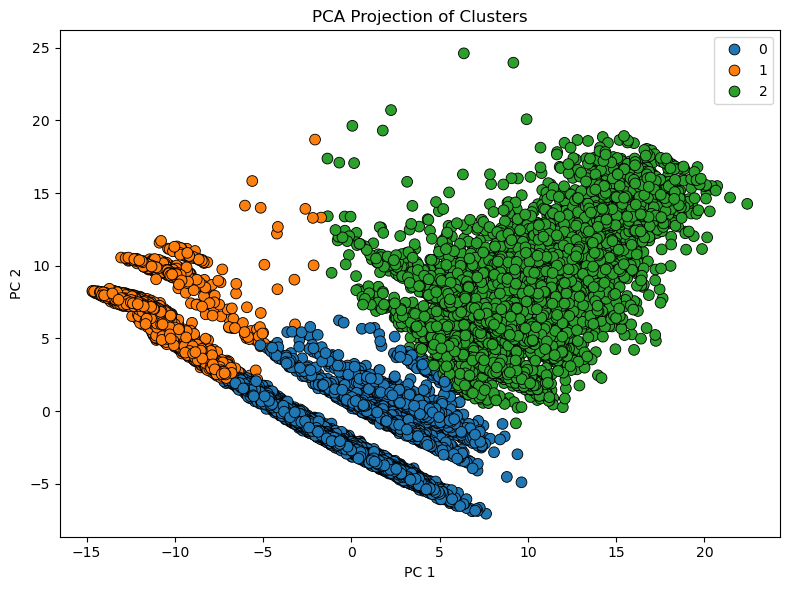

In [27]:
plot_pca(df_scaled, kmeans_labels)

In [28]:
top_feats_kmeans = list(set(sum(kmeans_top_vars.values(), [])))

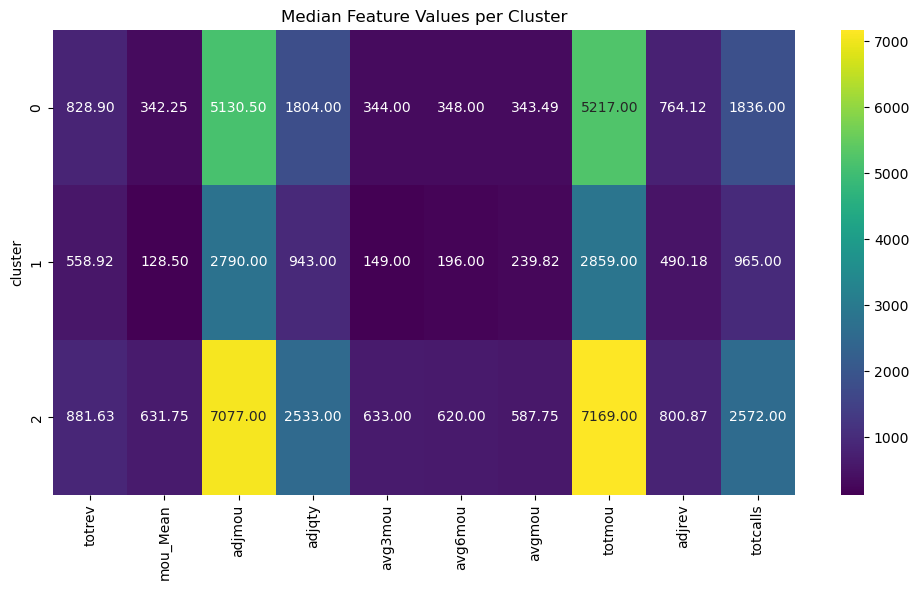

In [29]:
plot_cluster_heatmap(df_kmeans_labeled, kmeans_labels, top_feats_kmeans)

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


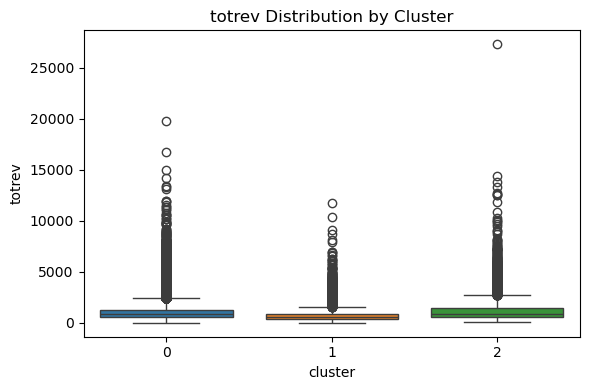

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


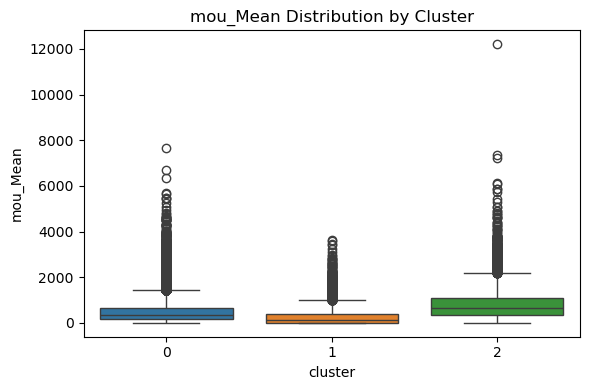

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


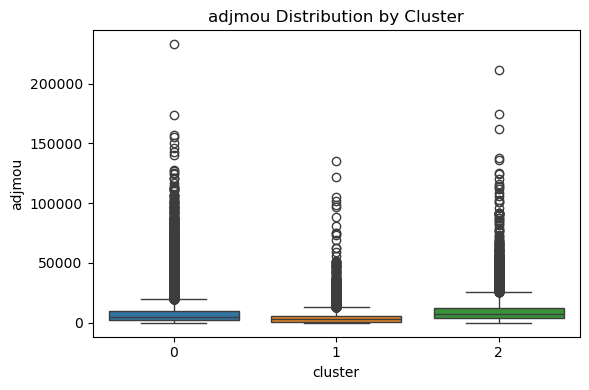

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


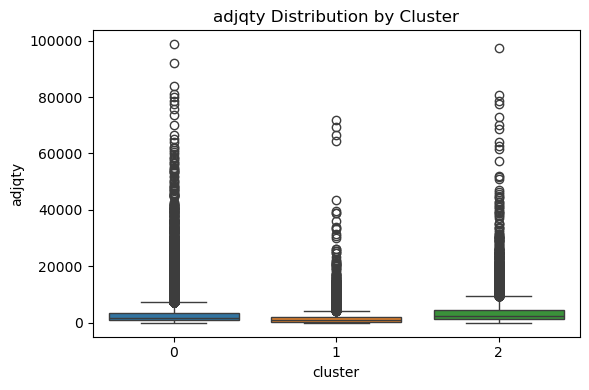

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


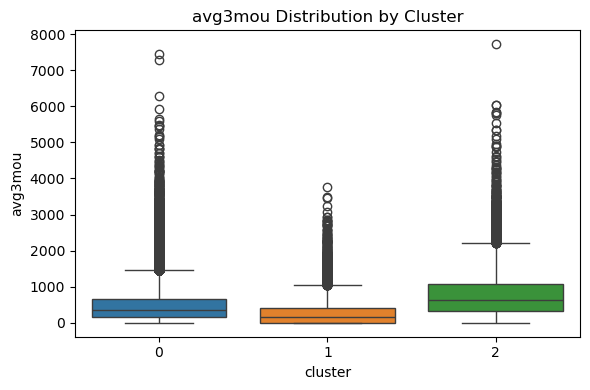

In [30]:
plot_feature_boxplots(df_kmeans_labeled, kmeans_labels, top_feats_kmeans[:5])

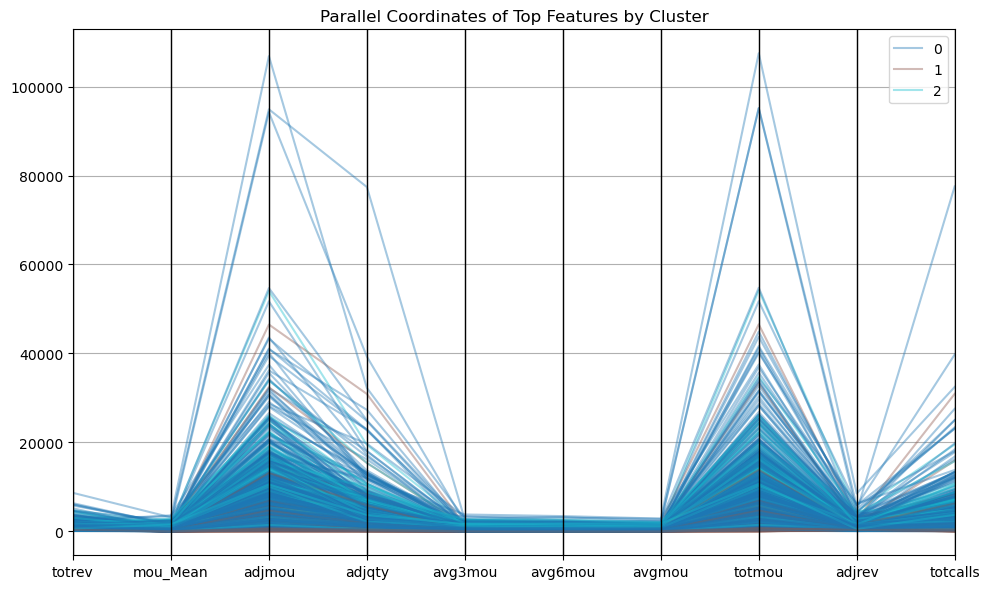

In [31]:
plot_parallel_coordinates(df_kmeans_labeled, kmeans_labels, top_feats_kmeans)

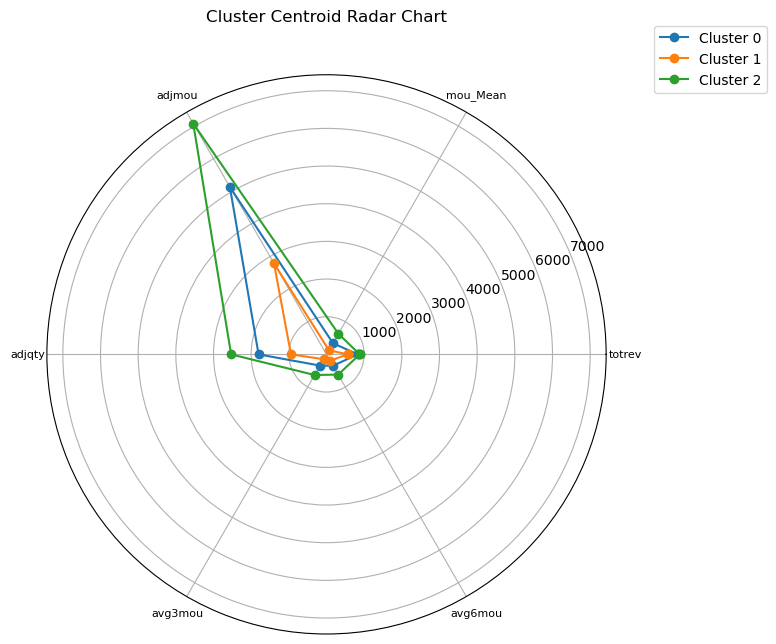

In [32]:
plot_radar_chart(df_kmeans_labeled, kmeans_labels, top_feats_kmeans[:6])

## GMM

In [33]:
gmm = GaussianMixture(n_components=3, random_state=RANDOM_STATE)
gmm_labels = gmm.fit_predict(df_scaled)

In [34]:
gmm_metrics = clustering_metrics(df_scaled, gmm_labels)
gmm_metrics

{'silhouette': 0.15856179785728602,
 'davies': 1.9159920035657638,
 'calinski': 19998.184387815323}

In [35]:
df_gmm_labeled = df_original.copy()
df_gmm_labeled["cluster"] = gmm_labels

In [36]:
gmm_summary = cluster_summary(df_gmm_labeled, gmm_labels)
show_summary(gmm_summary, caption="GMM Cluster Summary")

In [37]:
gmm_top_vars = top_variable(df_gmm_labeled, gmm_labels)
gmm_top_vars

{0: ['totmou',
  'adjmou',
  'totcalls',
  'adjqty',
  'totrev',
  'adjrev',
  'avg3mou',
  'mou_Mean',
  'avg6mou',
  'avgmou'],
 1: ['totmou',
  'adjmou',
  'totcalls',
  'adjqty',
  'totrev',
  'adjrev',
  'eqpdays',
  'avg3mou',
  'avg6mou',
  'avgmou'],
 2: ['totmou',
  'adjmou',
  'totcalls',
  'adjqty',
  'totrev',
  'adjrev',
  'avg3mou',
  'mou_Mean',
  'avg6mou',
  'avgmou']}

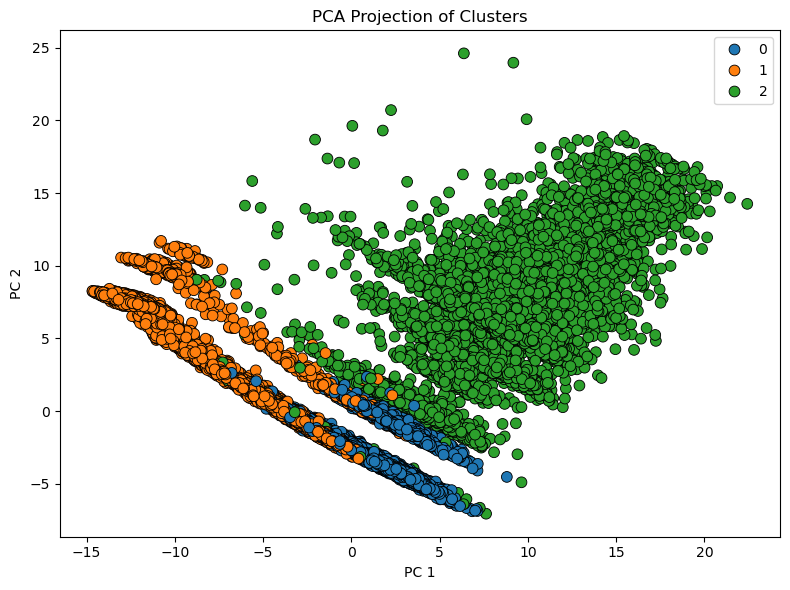

In [38]:
plot_pca(df_scaled, gmm_labels)

In [39]:
top_feats_gmm = list(set(sum(gmm_top_vars.values(), [])))

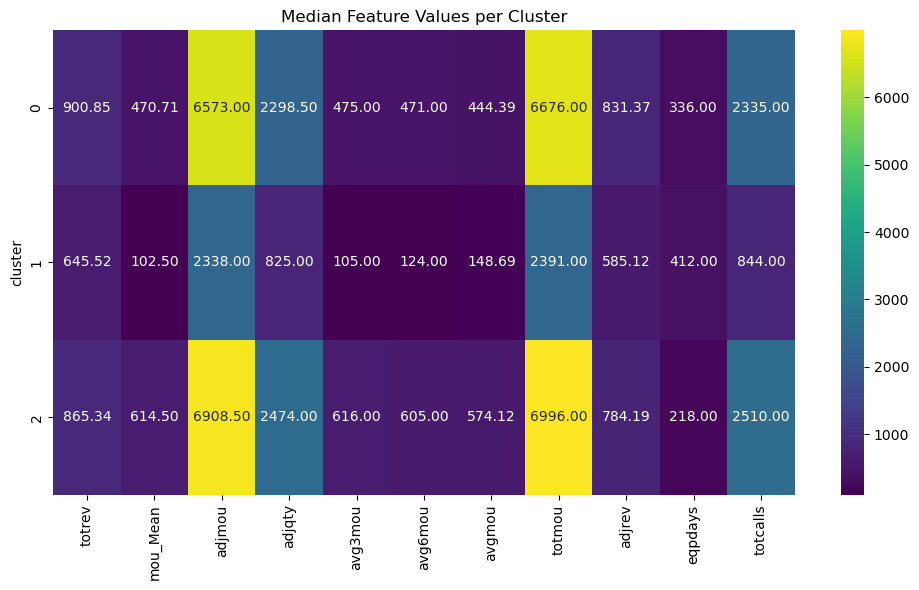

In [40]:
plot_cluster_heatmap(df_gmm_labeled, gmm_labels, top_feats_gmm)

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


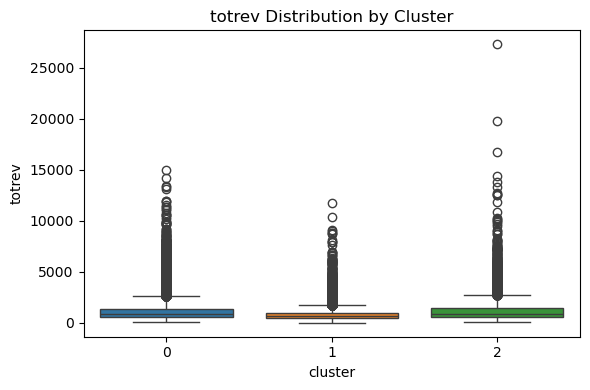

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


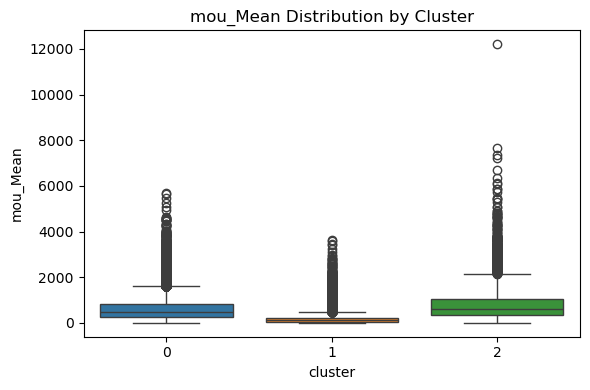

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


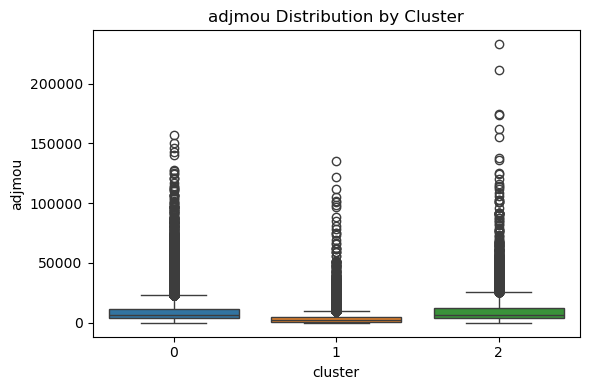

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


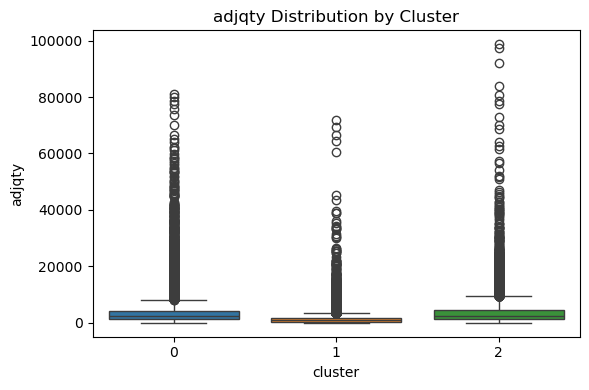

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


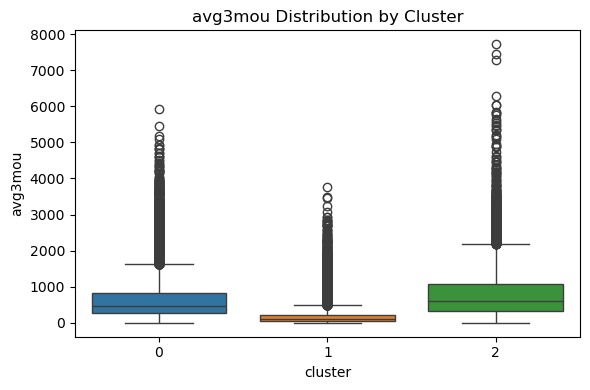

In [41]:
plot_feature_boxplots(df_gmm_labeled, gmm_labels, top_feats_gmm[:5])

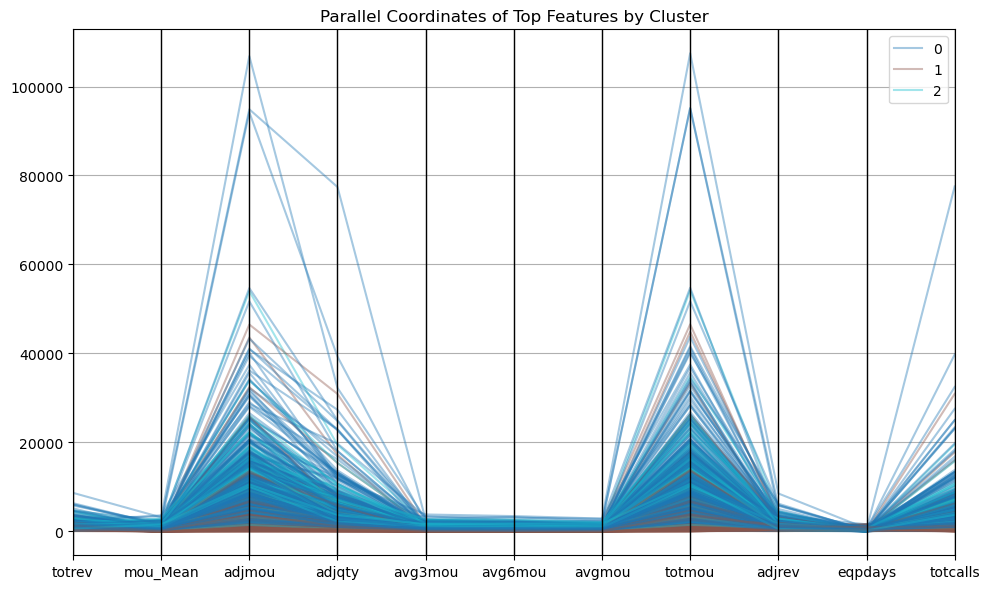

In [42]:
plot_parallel_coordinates(df_gmm_labeled, gmm_labels, top_feats_gmm)

## BIRCH

In [43]:
birch_model = Birch(n_clusters=None, threshold=5)
birch_sub_labels = birch_model.fit_predict(df_scaled)
birch_centers = birch_model.subcluster_centers_

In [44]:
k_final = 3
km_on_birch = KMeans(n_clusters=k_final, random_state=RANDOM_STATE)
birch_final_labels = km_on_birch.fit_predict(birch_centers)
birch_labels = np.array([birch_final_labels[i] for i in birch_sub_labels])

In [45]:
birch_metrics = clustering_metrics(df_scaled, birch_labels)
birch_metrics

{'silhouette': 0.30791068080651024,
 'davies': 1.62510224076555,
 'calinski': 14170.459124567014}

In [46]:
df_birch_labeled = df_original.copy()
df_birch_labeled["cluster"] = birch_labels

In [47]:
birch_summary = cluster_summary(df_birch_labeled, birch_labels)
show_summary(birch_summary, caption="Birch Cluster Summary")

In [48]:
birch_top_vars = top_variable(df_birch_labeled, birch_labels)
birch_top_vars

{0: ['totmou',
  'adjmou',
  'totcalls',
  'adjqty',
  'totrev',
  'adjrev',
  'avg3mou',
  'mou_Mean',
  'avg6mou',
  'avgmou'],
 1: ['totmou',
  'adjmou',
  'totcalls',
  'adjqty',
  'totrev',
  'adjrev',
  'avg3mou',
  'mou_Mean',
  'avg6mou',
  'avgmou'],
 2: ['totmou',
  'adjmou',
  'totcalls',
  'adjqty',
  'totrev',
  'adjrev',
  'mou_Mean',
  'avg3mou',
  'avg6mou',
  'change_mou']}

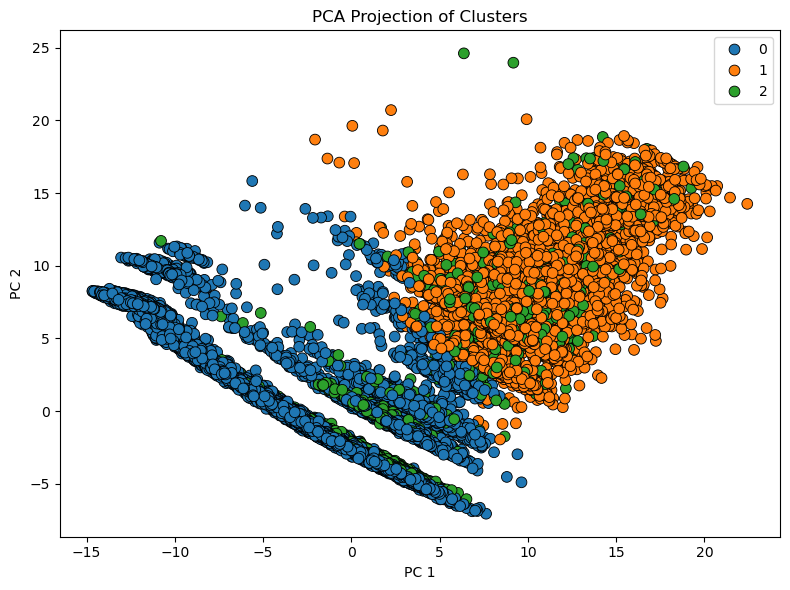

In [49]:
plot_pca(df_scaled, birch_labels)

In [50]:
top_feats_birch = list(set(sum(birch_top_vars.values(), [])))

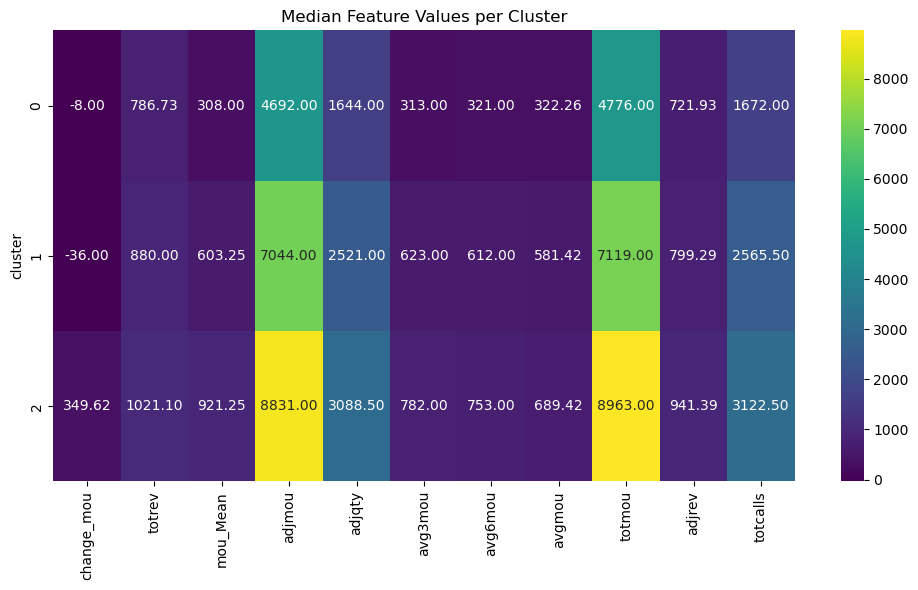

In [51]:
plot_cluster_heatmap(df_birch_labeled, birch_labels, top_feats_birch)

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


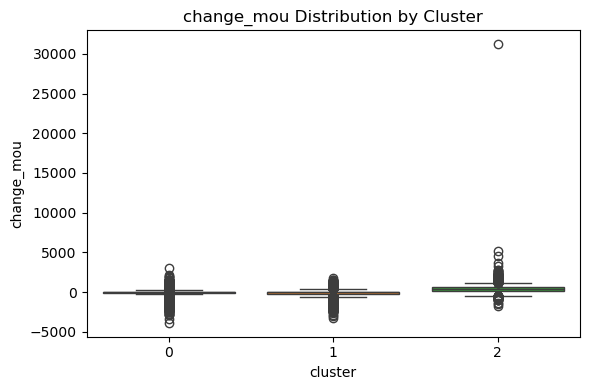

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


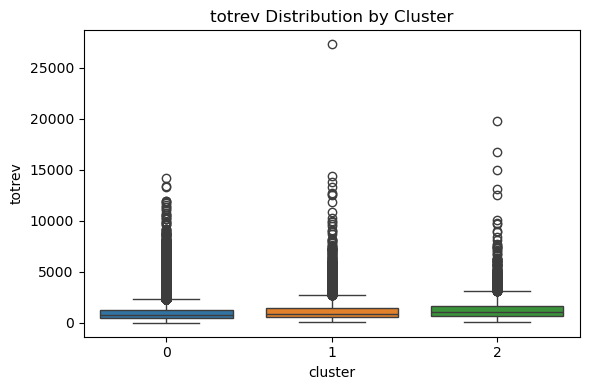

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


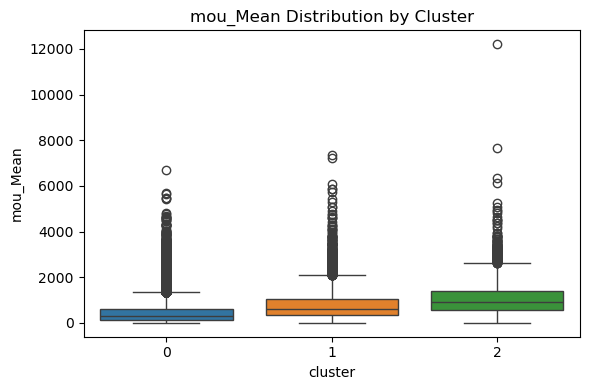

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


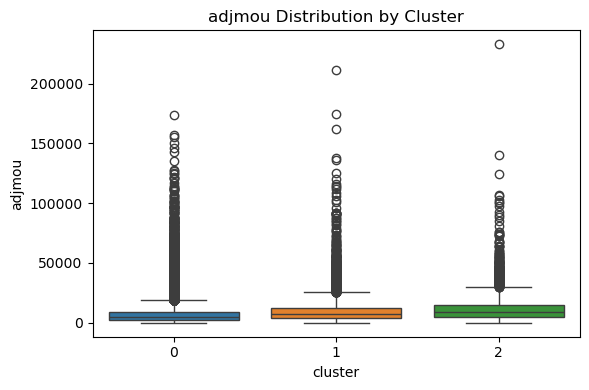

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


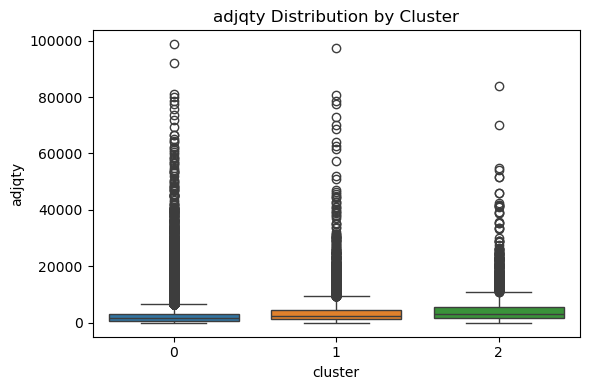

In [52]:
plot_feature_boxplots(df_birch_labeled, birch_labels, top_feats_birch[:5])

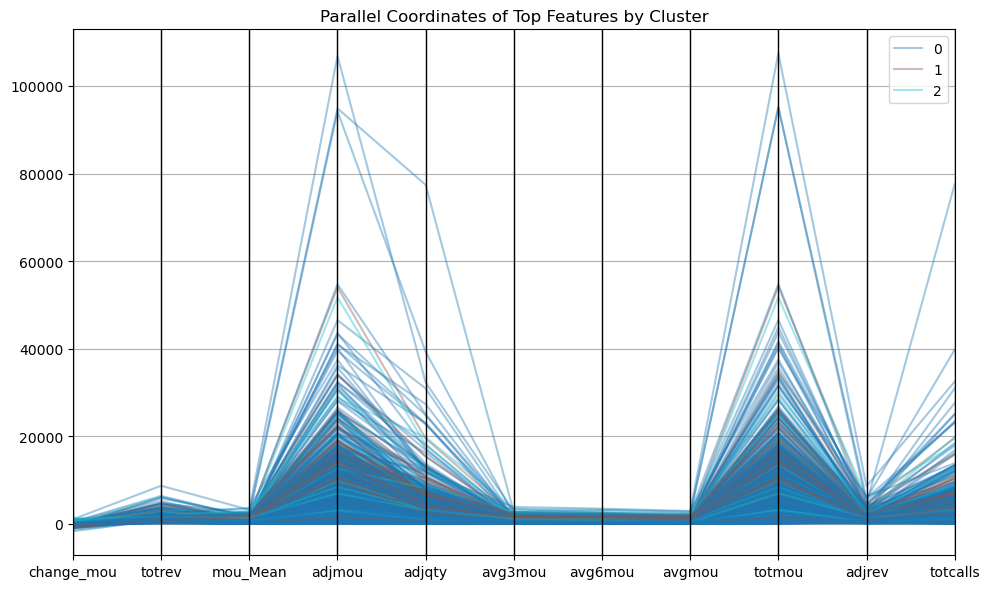

In [53]:
plot_parallel_coordinates(df_birch_labeled, birch_labels, top_feats_birch)

## HDBSCAN

In [54]:
hdb = hdbscan.HDBSCAN(min_cluster_size=650, min_samples=None)
hdb_labels = hdb.fit_predict(df_scaled)

C:\Users\Eden Thomas\.conda\envs\thesis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Eden Thomas\.conda\envs\thesis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [55]:
hdb_metrics = clustering_metrics(df_scaled, hdb_labels)
hdb_metrics

{'silhouette': 0.2087100306606237,
 'davies': 2.618193334486498,
 'calinski': 10675.156088943511}

In [56]:
df_hdb_labeled = df_original.copy()
df_hdb_labeled["cluster"] = hdb_labels

In [57]:
hdb_summary = cluster_summary(df_hdb_labeled, hdb_labels)
show_summary(hdb_summary, caption="HDBSCAN Cluster Summary")

In [58]:
hdb_top_vars = top_variable(df_hdb_labeled, hdb_labels)
hdb_top_vars

{-1: ['totmou',
  'adjmou',
  'totcalls',
  'adjqty',
  'totrev',
  'adjrev',
  'avg3mou',
  'mou_Mean',
  'avg6mou',
  'avgmou'],
 0: ['totmou',
  'adjmou',
  'totcalls',
  'adjqty',
  'totrev',
  'adjrev',
  'avg3mou',
  'mou_Mean',
  'avg6mou',
  'avgmou'],
 1: ['totmou',
  'adjmou',
  'totcalls',
  'adjqty',
  'totrev',
  'adjrev',
  'avg3mou',
  'mou_Mean',
  'avg6mou',
  'avgmou'],
 2: ['totmou',
  'adjmou',
  'totcalls',
  'adjqty',
  'totrev',
  'adjrev',
  'avg3mou',
  'mou_Mean',
  'avg6mou',
  'avgmou'],
 3: ['totmou',
  'adjmou',
  'totcalls',
  'adjqty',
  'totrev',
  'adjrev',
  'eqpdays',
  'avg3mou',
  'mou_Mean',
  'avg6mou']}

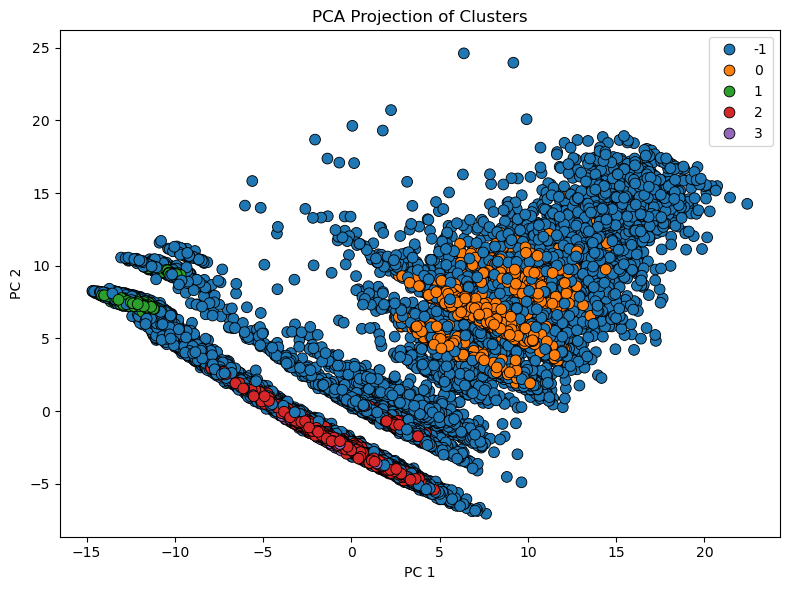

In [59]:
plot_pca(df_scaled, hdb_labels)

In [60]:
top_feats_hdb = list(set(sum(hdb_top_vars.values(), [])))

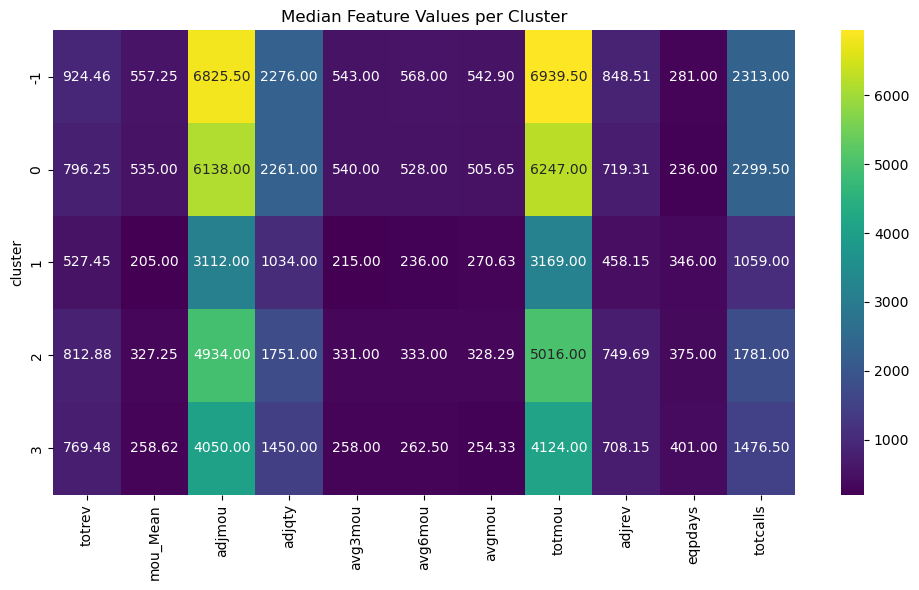

In [61]:
plot_cluster_heatmap(df_hdb_labeled, hdb_labels, top_feats_hdb)

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


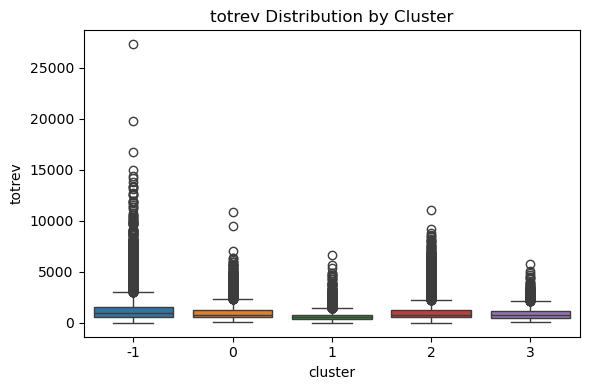

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


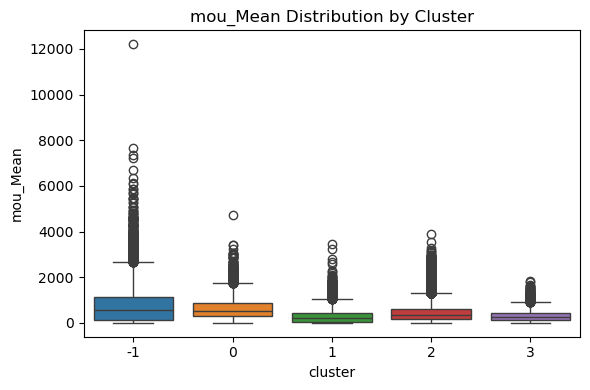

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


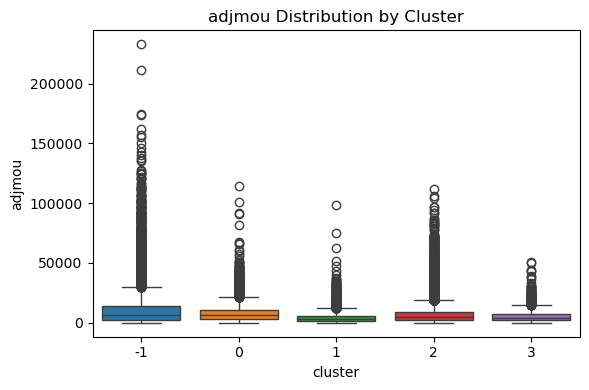

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


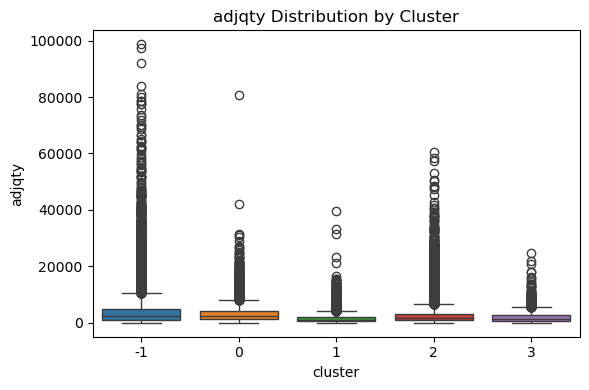

C:\Users\Eden Thomas\AppData\Local\Temp\ipykernel_6840\3435183386.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y=feature, data=df, palette="tab10")


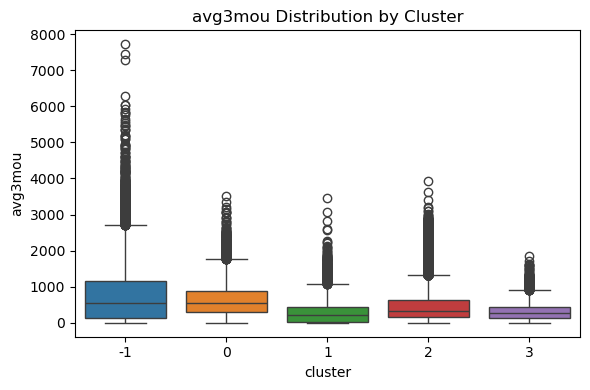

In [62]:
plot_feature_boxplots(df_hdb_labeled, hdb_labels, top_feats_hdb[:5])

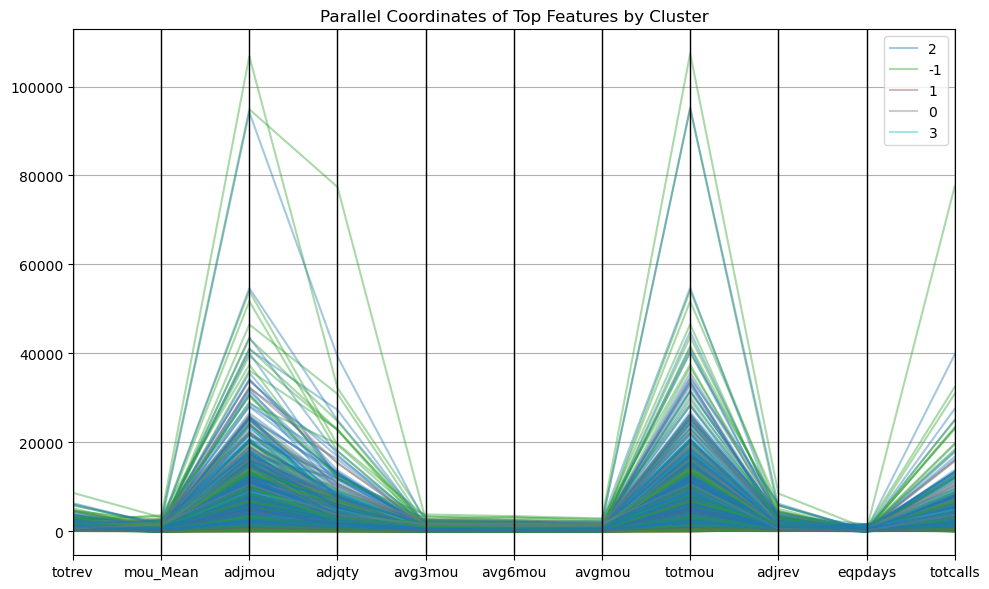

In [63]:
plot_parallel_coordinates(df_hdb_labeled, hdb_labels, top_feats_hdb)